In [2]:
# Exploratory Data Analysis (EDA) on Online Retail Dataset
# 
# ## Project Overview
# This notebook performs an Exploratory Data Analysis (EDA) on the Online Retail II dataset, which contains transactional data from an online retail store. The dataset spans from December 2009 to December 2011 and includes details such as invoices, products, quantities, prices, customers, and countries.
# 
# ### Objectives:
# - Understand the structure and quality of the data.
# - Identify patterns, trends, and anomalies.
# - Generate insights on sales, customer behavior, and product performance.
# - Visualize key metrics for better interpretation.
# 
# ### Dataset Source:
# - File: `online_retail_II.xlsx`
# - Sheets: "Year 2009-2010" and "Year 2010-2011"
# 
# ### Tools Used:
# - Python libraries: Pandas, NumPy, Matplotlib, Seaborn

## Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set visualization style
sns.set(style="whitegrid")
%matplotlib inline

## Step 2: Load the Data

In [4]:
# Load the two sheets from the Excel file and combine them into a single DataFrame.
# OPTIMIZED SOLUTION: Convert Excel to CSV first (much faster for large files)

import os

# Check if file exists and get its size
file_path = 'online_retail_II.xlsx'
if os.path.exists(file_path):
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
    print(f"Excel file size: {file_size:.2f} MB")
    print(f"\nLarge Excel files ({int(file_size)}MB) are EXTREMELY slow to load with pd.read_excel().")
    print("Solution: Convert to CSV once, then read from CSV (10-100x faster).\n")
else:
    print(f"File not found: {file_path}")

# Check if CSV files already exist (from previous conversion)
csv_2009 = 'online_retail_2009_2010.csv'
csv_2010 = 'online_retail_2010_2011.csv'

if os.path.exists(csv_2009) and os.path.exists(csv_2010):
    print("CSV files found! Loading from CSV (fast)...\n")
    
    print("Loading Year 2009-2010 data from CSV...")
    df_2009_2010 = pd.read_csv(csv_2009)
    print(f"Loaded {len(df_2009_2010):,} rows")
    
    print("Loading Year 2010-2011 data from CSV...")
    df_2010_2011 = pd.read_csv(csv_2010)
    print(f"Loaded {len(df_2010_2011):,} rows")
    
else:
    print("CSV files not found. Converting Excel to CSV (one-time operation)...")
    print("This may take 2-5 minutes but will be much faster next time.\n")
    
    print("Converting Year 2009-2010 sheet to CSV...")
    df_2009_2010 = pd.read_excel(file_path, sheet_name='Year 2009-2010', engine='openpyxl')
    df_2009_2010.to_csv(csv_2009, index=False)
    print(f"Saved {len(df_2009_2010):,} rows to {csv_2009}")
    
    print("Converting Year 2010-2011 sheet to CSV...")
    df_2010_2011 = pd.read_excel(file_path, sheet_name='Year 2010-2011', engine='openpyxl')
    df_2010_2011.to_csv(csv_2010, index=False)
    print(f"Saved {len(df_2010_2011):,} rows to {csv_2010}")
    print("\nCSV files created successfully! Future loads will be much faster.")

# Combine the DataFrames
print("\nCombining dataframes...")
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
print(f"Total rows in combined dataset: {len(df):,}")

# Display the first few rows
print("\nFirst 5 rows:")
print(df.head())

# Display basic info
print("\nDataFrame Info:")
df.info()

Excel file size: 43.51 MB

Large Excel files (43MB) are EXTREMELY slow to load with pd.read_excel().
Solution: Convert to CSV once, then read from CSV (10-100x faster).

CSV files found! Loading from CSV (fast)...

Loading Year 2009-2010 data from CSV...
Loaded 525,461 rows
Loading Year 2010-2011 data from CSV...
Loaded 541,910 rows

Combining dataframes...
Total rows in combined dataset: 1,067,371

First 5 rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085

## Step 3: Data Cleaning

# ### 3.1 Handle Missing Values

In [5]:
# Check for missing values and decide on imputation or removal.

# Check missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Drop rows with missing Customer ID (critical for customer analysis)
df = df.dropna(subset=['Customer ID'])

# Fill missing descriptions with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

Missing Values:
 Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64


# ### 3.2 Handle Duplicates

In [6]:
# Remove any duplicate rows if present.

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates
df = df.drop_duplicates()

Number of duplicate rows: 26479


# ### 3.3 Data Type Corrections

In [13]:
# - Convert `InvoiceDate` to datetime.
# - Ensure `Quantity` and `Price` are numeric.
# - Convert `Customer ID` to integer.

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Ensure Quantity and Price are numeric
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop any rows with invalid Quantity or Price (e.g., negative quantities might indicate returns)
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Convert Customer ID to int
df['Customer ID'] = df['Customer ID'].astype(int)

# ### 3.4 Feature Engineering

In [15]:
# - Create `TotalPrice` as Quantity * Price.
# - Extract date components: Year, Month, Day, Hour.

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

In [16]:
# Extract date components
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Display cleaned data summary
df.describe()

,Quantity,Price,Customer ID,TotalPrice,Year,Month,Day,Hour,Weekday
count,779425.000000,779425.000000,779425.000000,779425.000000,779425.000000,779425.000000,779425.000000,779425.000000,779425.000000
mean,13.489370,3.218488,15320.360461,22.291823,2010.432051,7.417059,15.390961,12.791884,2.641669
std,145.855814,29.676140,1695.692775,227.427075,0.568385,3.422319,8.657939,2.294182,1.951163
min,1.000000,0.001000,12346.000000,0.001000,2009.000000,1.000000,1.000000,6.000000,0.000000
25%,2.000000,1.250000,13971.000000,4.950000,2010.000000,5.000000,8.000000,11.000000,1.000000
50%,6.000000,1.950000,15247.000000,12.480000,2010.000000,8.000000,15.000000,13.000000,2.000000
75%,12.000000,3.750000,16794.000000,19.800000,2011.000000,11.000000,23.000000,14.000000,4.000000
max,80995.000000,10953.500000,18287.000000,168469.600000,2011.000000,12.000000,31.000000,20.000000,6.000000


# ## Step 4: Univariate Analysis

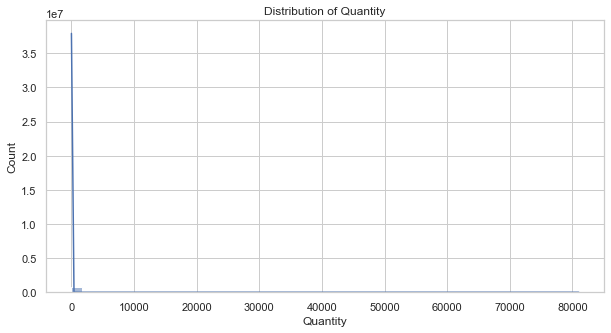

In [17]:
# Analyze individual variables for distributions and outliers.

# ### 4.1 Numerical Variables

# Distribution of Quantity
plt.figure(figsize=(10, 5))
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity')
plt.show()

# Distribution of Price

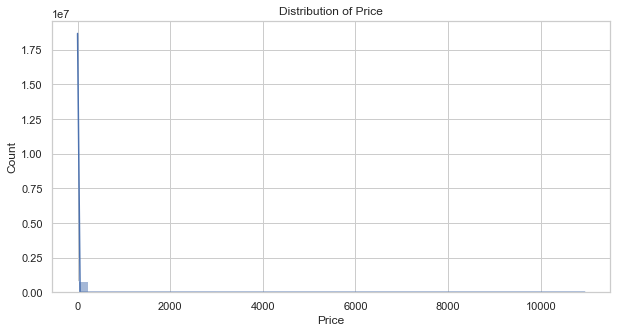

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.show()

# Distribution of TotalPrice

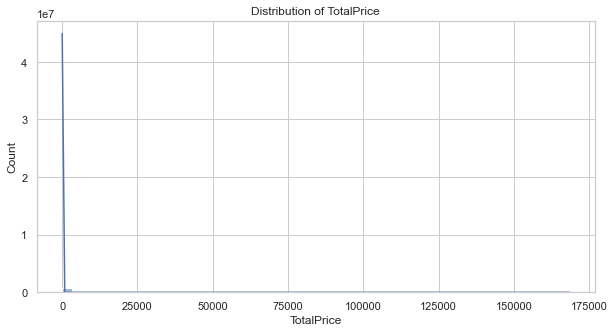

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df['TotalPrice'], bins=50, kde=True)
plt.title('Distribution of TotalPrice')
plt.show()

# ### 4.2 Categorical Variables

# Top 10 Countries

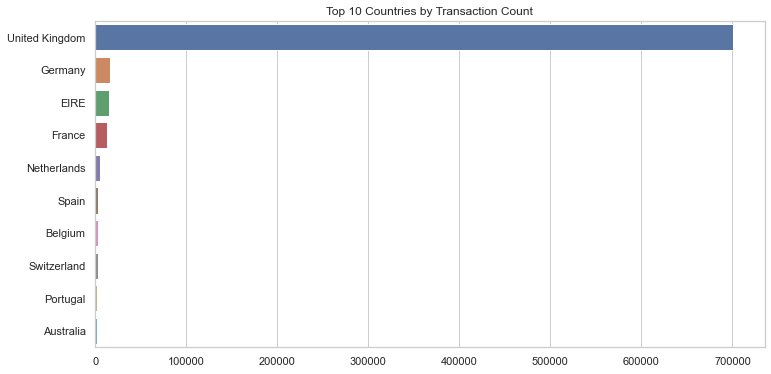

In [20]:
plt.figure(figsize=(12, 6))
top_countries = df['Country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Transaction Count')
plt.show()

# Top 10 Products by Description

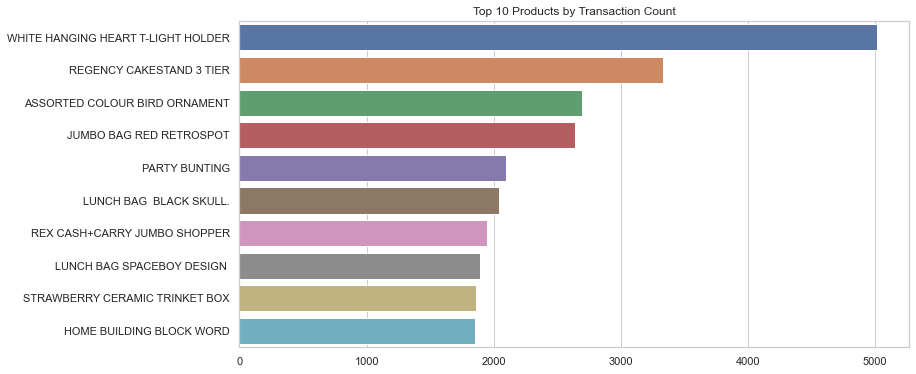

In [21]:
plt.figure(figsize=(12, 6))
top_products = df['Description'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Products by Transaction Count')
plt.show()

# ## Step 5: Bivariate Analysis

# Explore relationships between variables.

# ### 5.1 Sales Over Time

# Monthly Sales Trend

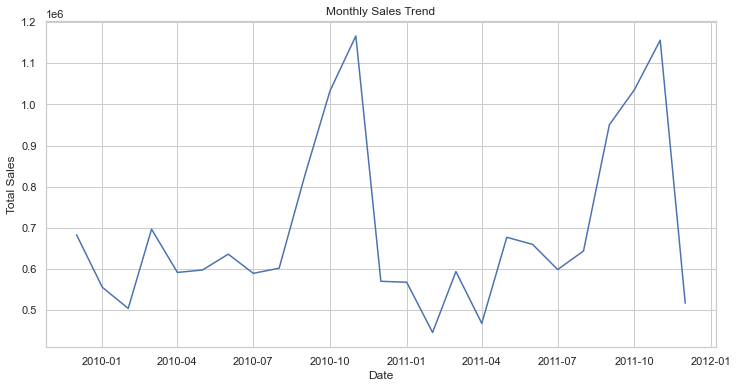

In [22]:
monthly_sales = df.groupby(['Year', 'Month'])['TotalPrice'].sum().reset_index()

monthly_sales['Date'] = pd.to_datetime(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str) + '-01')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='TotalPrice', data=monthly_sales)
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [ ]:
# ### 5.2 Sales by Country

# Total Sales by Country (Top 10)

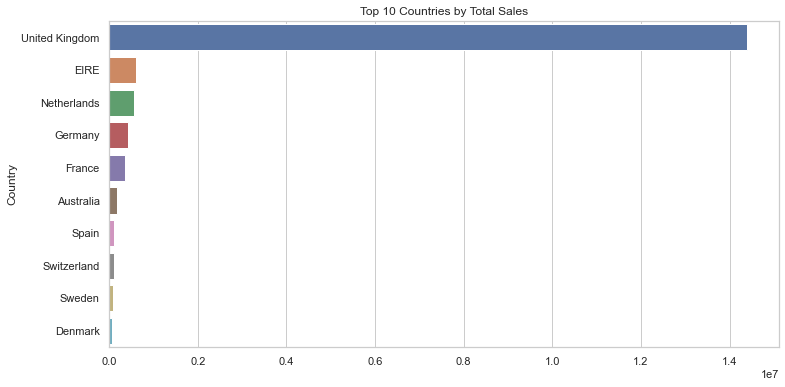

In [23]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title('Top 10 Countries by Total Sales')
plt.show()

# ### 5.3 Quantity vs Price

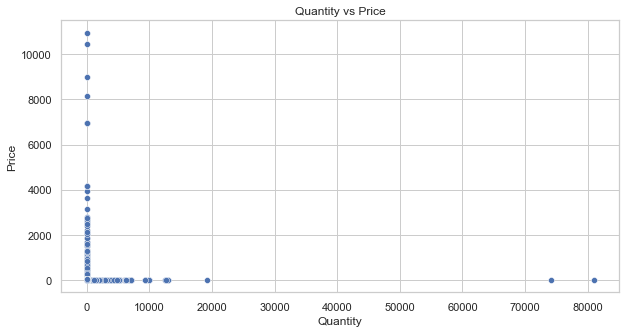

In [24]:
# Scatter plot of Quantity vs Price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Quantity', y='Price', data=df)
plt.title('Quantity vs Price')
plt.show()

# ## Step 6: Multivariate Analysis

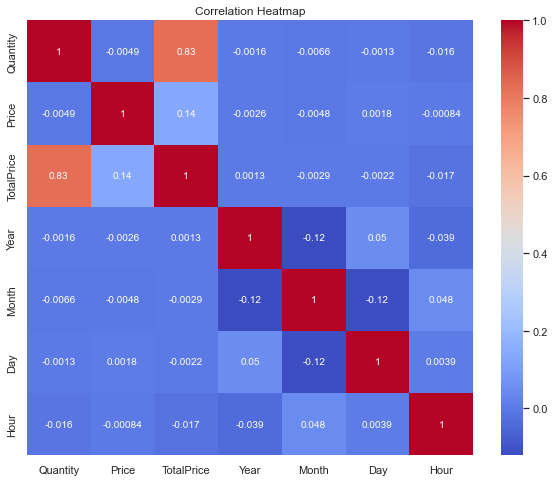

In [26]:
#Select numerical columns for correlation
num_cols = ['Quantity', 'Price', 'TotalPrice', 'Year', 'Month', 'Day', 'Hour']
corr_matrix = df[num_cols].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# ### 6.2 Sales by Hour and Weekday

# Pivot table for heatmap

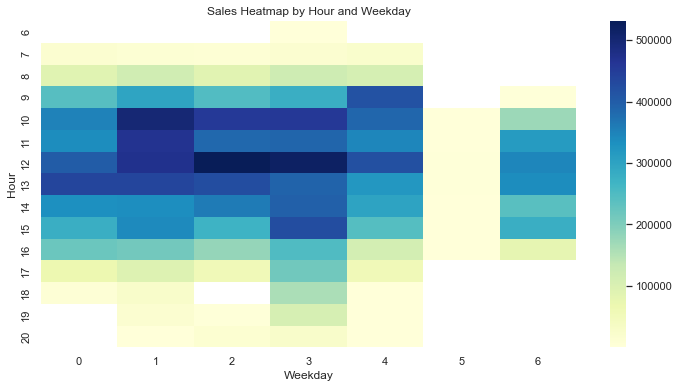

In [28]:
hour_weekday_sales = df.pivot_table(index='Hour', columns='Weekday', values='TotalPrice', aggfunc='sum')

plt.figure(figsize=(12, 6))
sns.heatmap(hour_weekday_sales, cmap='YlGnBu', annot=False)
plt.title('Sales Heatmap by Hour and Weekday')
plt.show()

# ## Step 7: Customer Analysis

# ### 7.1 Top Customers by Total Spend

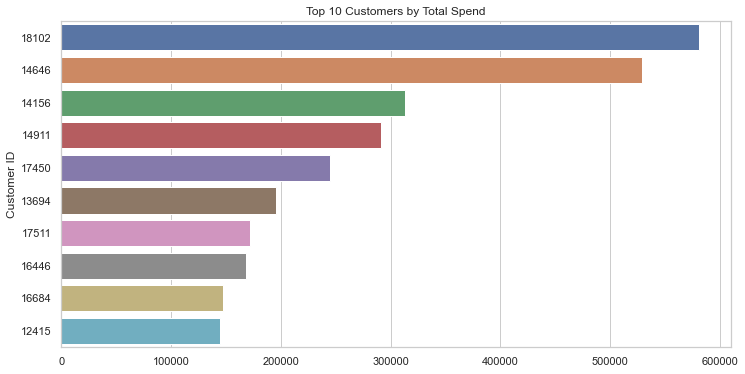

In [29]:
top_customers = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_customers.values, y=top_customers.index.astype(str))
plt.title('Top 10 Customers by Total Spend')
plt.show()

# ### 7.2 Number of Unique Customers per Country

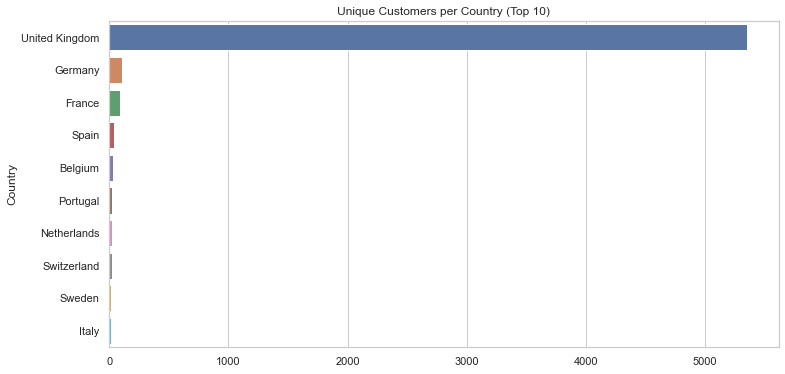

In [30]:
unique_customers_country = df.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_customers_country.values, y=unique_customers_country.index)
plt.title('Unique Customers per Country (Top 10)')
plt.show()

# ## Step 8: Outlier Detection

# Boxplot for Quantity

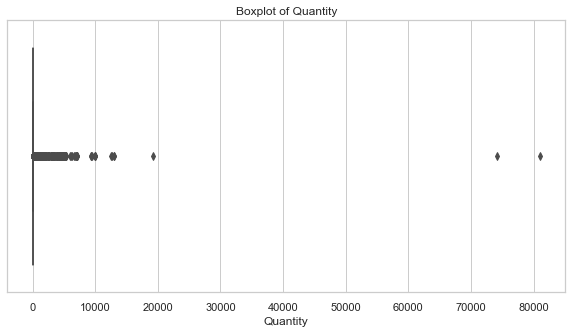

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot of Quantity')
plt.show()

# Boxplot for Price

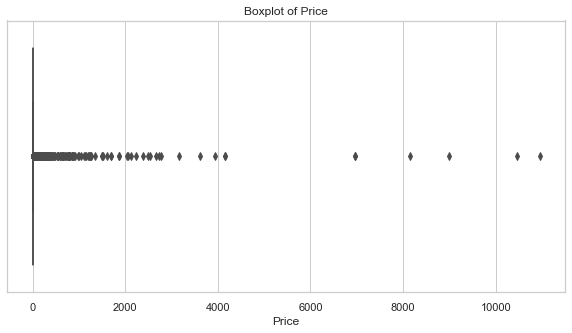

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Price'])
plt.title('Boxplot of Price')
plt.show()

# Boxplot for TotalPrice

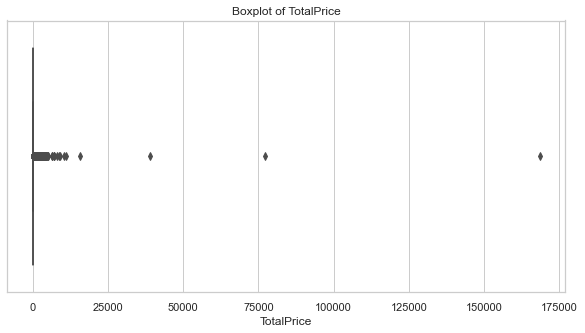

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['TotalPrice'])
plt.title('Boxplot of TotalPrice')
plt.show()

# ## Step 9: Key Insights and Conclusions
# 
# - **Data Quality**: After cleaning, the dataset has no missing critical values and positive quantities/prices.
# - **Sales Trends**: Sales show seasonal patterns, with peaks likely around holidays.
# - **Top Performers**: United Kingdom dominates in transactions and sales. Popular products include decorative items and gifts.
# - **Customer Behavior**: A small number of customers contribute significantly to revenue. Peak sales hours are during business times.
# - **Recommendations**: Focus on high-value customers, stock popular items, and explore international expansion.
# 
# This EDA provides a solid foundation for further analysis, such as RFM (Recency, Frequency, Monetary) modeling or predictive analytics.